In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [108]:
import numpy as np
import pandas as pd
import copy
import open3d as o3
from pathlib import Path
import openslide

In [292]:
from probreg import transformation as tf

In [148]:
from probreg import cpd
from probreg import callbacks
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Next steps

- Verbessern der transformation iterrativ um den ausgangspunkt

In [234]:
def draw_annos(image, frame):
        
    f = plt.figure(figsize=(24,24))
    ax = f.subplots(1)

    ax.imshow(image)

    for x1, y1, x2, y2, pred in zip(frame["x1"], frame["y1"], frame["x2"], frame["y2"], frame["label"]):

        color = 'r'
        if int(pred) == 0:
            color = 'g'
        elif int(pred) == 1:
            color = 'b'
        elif int(pred) == 2:
            color = 'y'
        elif int(pred) == 3:
            color = 'm'

        rect = patches.Rectangle((x1, y1),y2-y1, x2-x1,linewidth=3,edgecolor=color,facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

In [23]:
df = pd.read_pickle("reg_results.p")

df["center_x"] = [x1 + ((x2-x1) / 2) for x1, x2 in zip(df["x1"], df["x2"])]
df["center_y"] = [y1 + ((y2-y1) / 2) for y1, y2 in zip(df["y1"], df["y2"])]

df.head()

file         scanner image_nr  width  height  \
0  24_EIPH_576255 Berliner Blau.svs  NanoZoomerS210   576255  34200   32356   
1  24_EIPH_576255 Berliner Blau.svs  NanoZoomerS210   576255  34200   32356   
2  24_EIPH_576255 Berliner Blau.svs  NanoZoomerS210   576255  34200   32356   
3  24_EIPH_576255 Berliner Blau.svs  NanoZoomerS210   576255  34200   32356   
4  24_EIPH_576255 Berliner Blau.svs  NanoZoomerS210   576255  34200   32356   

        x1       y1       x2       y2  label     score  
0  10978.0   7036.0  11107.0   7166.0    4.0  0.929032  
1  30033.0  13813.0  30201.0  13981.0    2.0  0.926395  
2  18278.0   4283.0  18394.0   4399.0    1.0  0.926342  
3  25220.0  11058.0  25328.0  11167.0    1.0  0.925790  
4  12767.0  22738.0  12885.0  22856.0    1.0  0.922600

In [369]:
file_scanner = {
    "24_EIPH_576255 Berliner Blau.svs": "Aperio",
    "Z_BB_576255_1.tif": "AxioScan",
    "N2_BB_576255_1.ndpi": "NanoZoomer2.0HT",
    "N1_BB_576255_1.ndpi": "NanoZoomerS210",
}

scanner_list = []
for file in df["file"].unique():
    
    scanner = file_scanner[file]
    scannerDf = df[df["file"]==file]
    
    grade = scannerDf["label"].mean() * 100
    
    _0 = len(scannerDf[scannerDf["label"]==0])
    _1 = len(scannerDf[scannerDf["label"]==1])
    _2 = len(scannerDf[scannerDf["label"]==2])
    _3 = len(scannerDf[scannerDf["label"]==3])
    _4 = len(scannerDf[scannerDf["label"]==4])
    
    scanner_list.append([scanner, len(scannerDf), grade, _0, _1, _2, _3, _4])

scanner_list = pd.DataFrame(scanner_list, columns=["Scanner", "Count", "Grade", "0", "1", "2", "3", "4"])
scanner_list

Scanner  Count       Grade     0     1     2     3    4
0           Aperio   7918  131.598889  1326  3258  2898   378   58
1         AxioScan   9145   94.915254  2639  4828  1255   350   73
2  NanoZoomer2.0HT   8171  128.809203  1173  3904  2731   293   70
3   NanoZoomerS210   8178  148.801663  1277  2946  2756  1085  114

In [38]:
scannerDf = df[df["file"]=="Z_BB_576255_1.tif"]
scannerDf.head()

file         scanner image_nr  width  height       x1  \
7918  Z_BB_576255_1.tif  NanoZoomerS210   576255  39118   39019  16373.0   
7919  Z_BB_576255_1.tif  NanoZoomerS210   576255  39118   39019  17293.0   
7920  Z_BB_576255_1.tif  NanoZoomerS210   576255  39118   39019  10732.0   
7921  Z_BB_576255_1.tif  NanoZoomerS210   576255  39118   39019  30524.0   
7922  Z_BB_576255_1.tif  NanoZoomerS210   576255  39118   39019  10584.0   

           y1       x2       y2  label     score  
7918   4992.0  16497.0   5116.0    1.0  0.956942  
7919   8517.0  17419.0   8644.0    1.0  0.953454  
7920  11534.0  10880.0  11683.0    1.0  0.951450  
7921  17406.0  30650.0  17523.0    1.0  0.950668  
7922  25678.0  10697.0  25791.0    1.0  0.950200

In [46]:
df.head()

file         scanner image_nr  width  height  \
0  24_EIPH_576255 Berliner Blau.svs  NanoZoomerS210   576255  34200   32356   
1  24_EIPH_576255 Berliner Blau.svs  NanoZoomerS210   576255  34200   32356   
2  24_EIPH_576255 Berliner Blau.svs  NanoZoomerS210   576255  34200   32356   
3  24_EIPH_576255 Berliner Blau.svs  NanoZoomerS210   576255  34200   32356   
4  24_EIPH_576255 Berliner Blau.svs  NanoZoomerS210   576255  34200   32356   

        x1       y1       x2       y2  label     score  center_x  center_y  
0  10978.0   7036.0  11107.0   7166.0    4.0  0.929032   11042.5    7101.0  
1  30033.0  13813.0  30201.0  13981.0    2.0  0.926395   30117.0   13897.0  
2  18278.0   4283.0  18394.0   4399.0    1.0  0.926342   18336.0    4341.0  
3  25220.0  11058.0  25328.0  11167.0    1.0  0.925790   25274.0   11112.5  
4  12767.0  22738.0  12885.0  22856.0    1.0  0.922600   12826.0   22797.0

In [47]:
from probreg import cpd

In [164]:
filteredDf = df[df["score"] > 0.5]

s210 = filteredDf[filteredDf["file"]=="N1_BB_576255_1.ndpi"] #"N1_BB_576255_1.ndpi"
s2 = filteredDf[filteredDf["file"]=="N2_BB_576255_1.ndpi"]

In [165]:
source =  np.array([[center_x, center_y] for center_x, center_y in zip(s210["center_x"], s210["center_y"])])
target =  np.array([[center_x, center_y] for center_x, center_y in zip(s2["center_x"], s2["center_y"])])

print(f"Source: {source.shape}")
print(f"Target: {target.shape}")

Source: (7622, 2)
Target: (7686, 2)


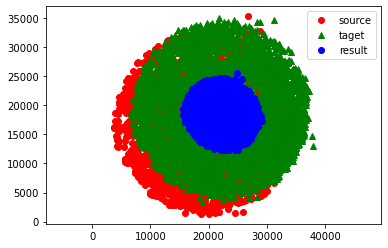

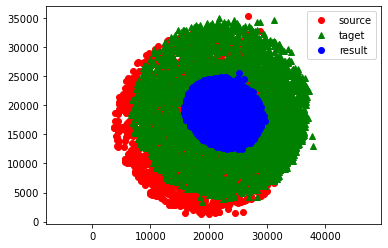

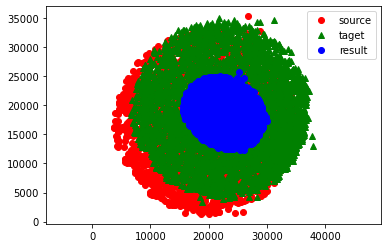

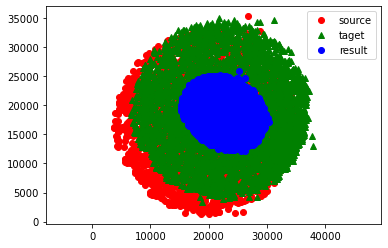

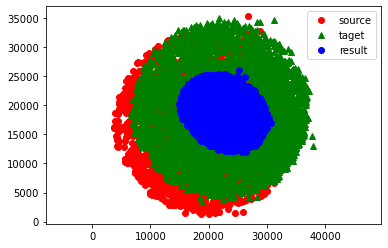

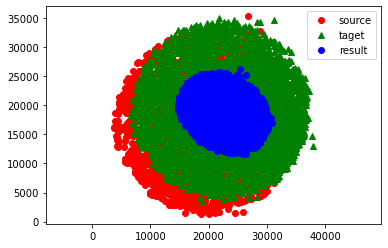

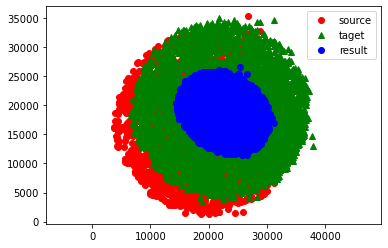

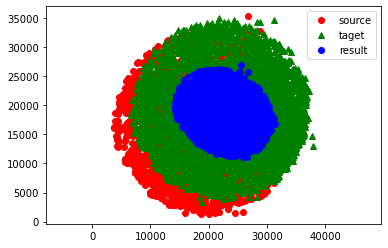

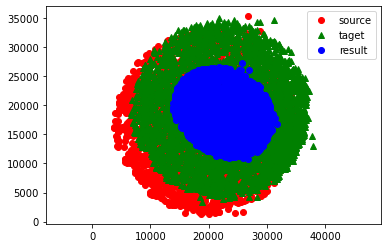

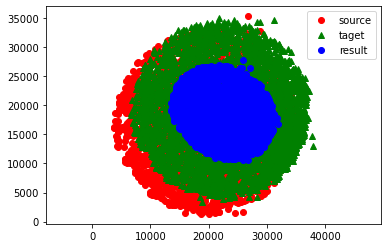

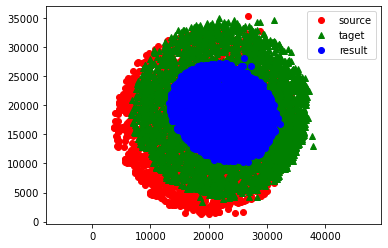

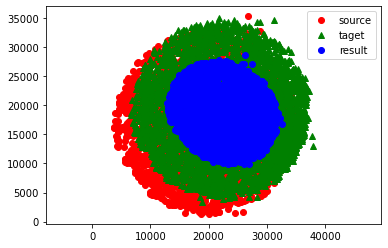

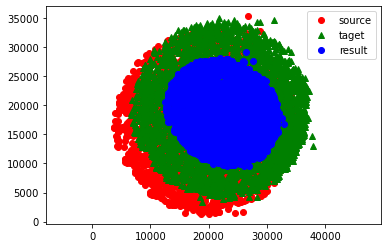

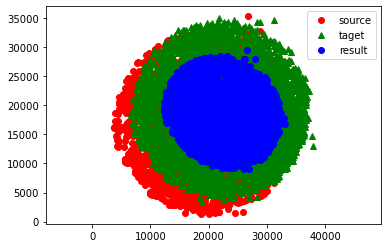

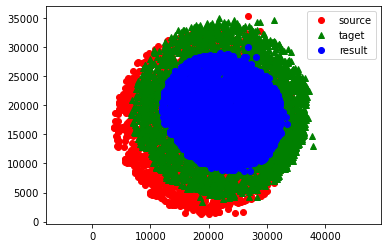

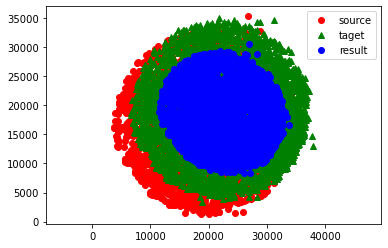

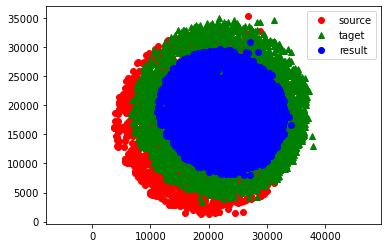

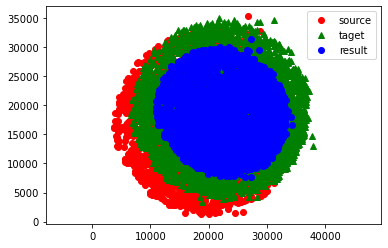

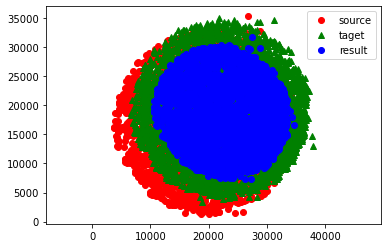

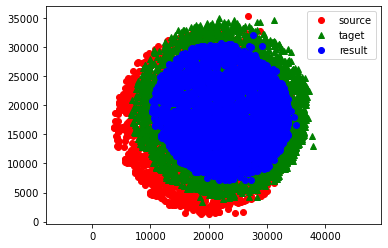

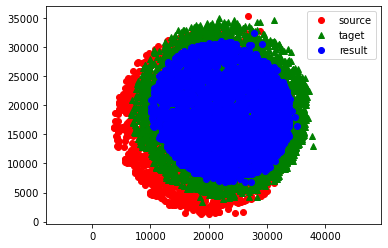

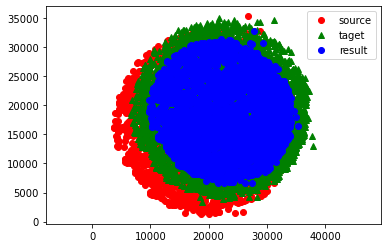

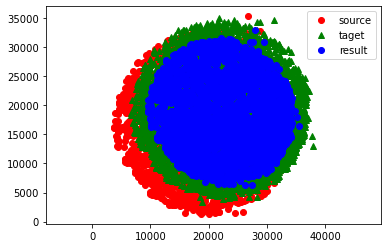

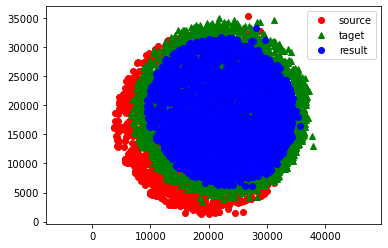

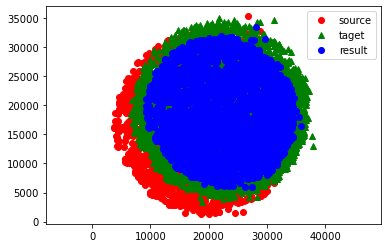

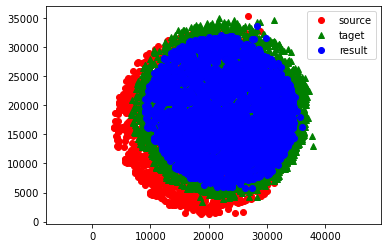

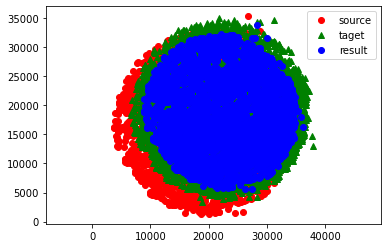

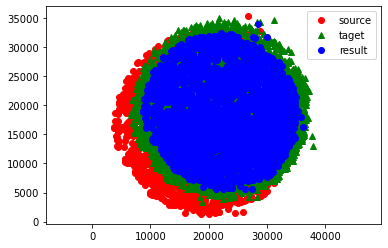

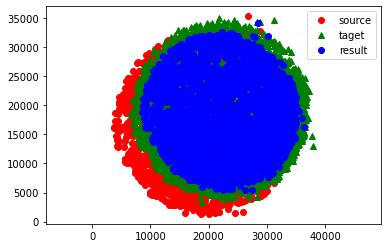

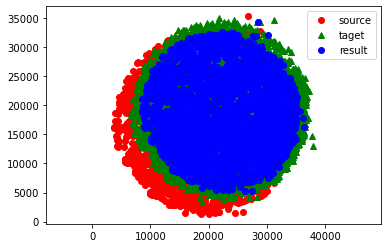

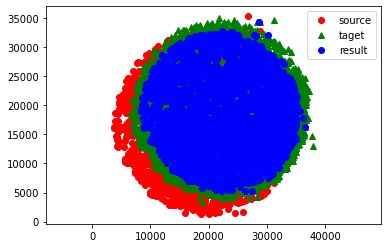

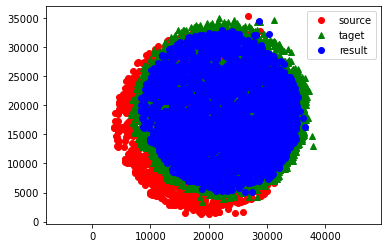

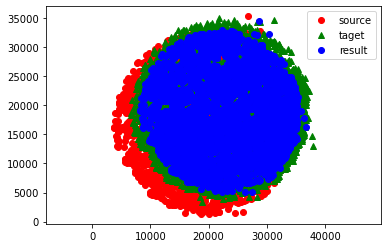

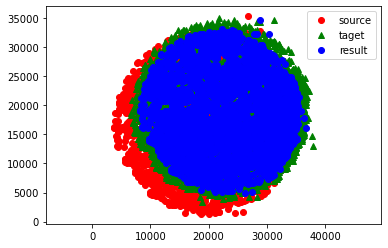

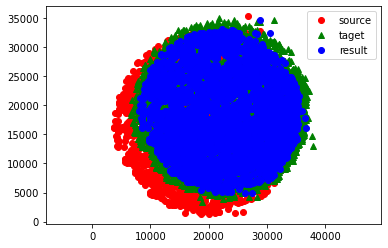

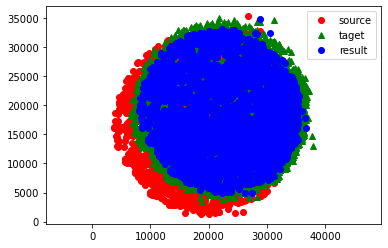

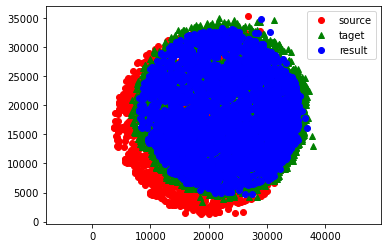

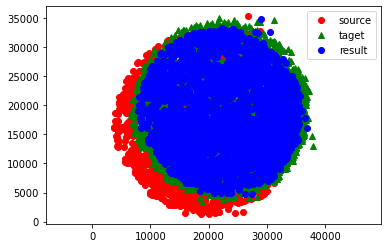

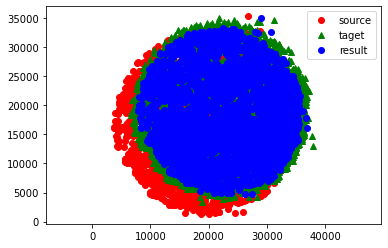

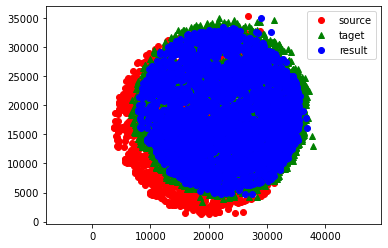

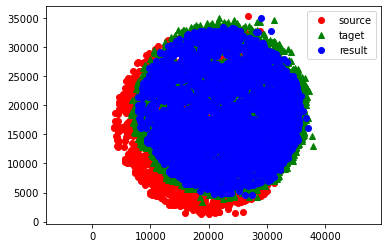

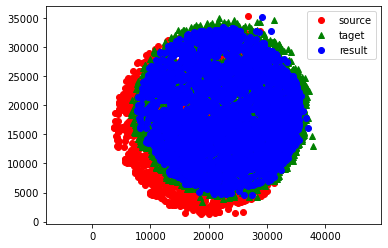

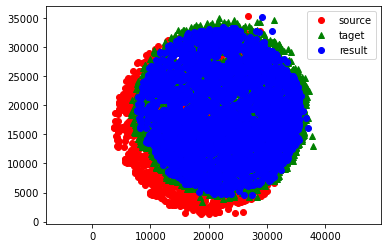

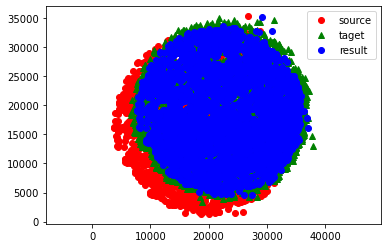

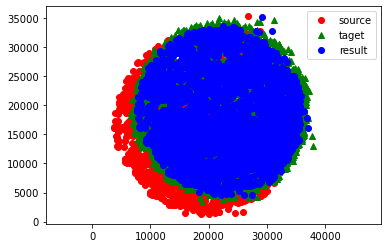

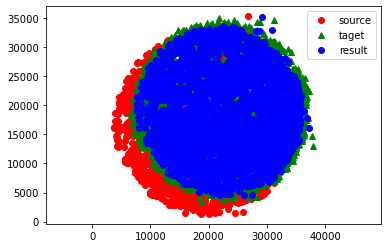

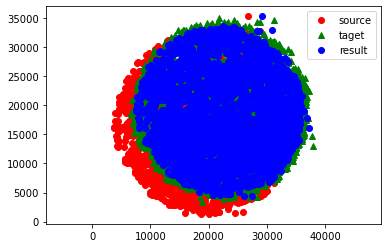

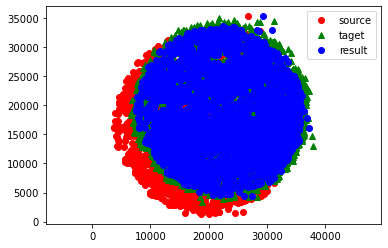

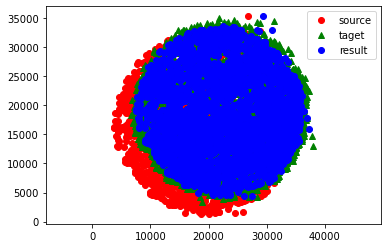

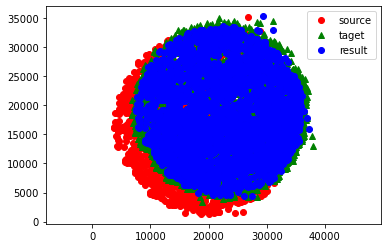

In [126]:
#https://probreg.readthedocs.io/en/latest/probreg.html#probreg.cpd.registration_cpd

# compute cpd registration
cbs = [callbacks.Plot2DCallback(source, target)]
tf_param, _, _ = cpd.registration_cpd(source, target, 'affine'
                                      , callbacks=cbs) # ‘rigid’, ‘affine’, ‘nonrigid’
plt.show()

In [127]:
source

array([[15686. , 15784.5],
       [11088. ,  5803. ],
       [24290. , 11901.5],
       ...,
       [31945.5,  9848. ],
       [15842.5, 11886.5],
       [30220.5,  6962.5]])

In [128]:
tf_param.transform(source)

array([[18462.51790464, 18110.58332606],
       [13936.15558449,  9212.82366005],
       [26250.03066546, 13980.17261311],
       ...,
       [33221.44416297, 11595.93258807],
       [18488.39389333, 14510.14487748],
       [31549.30932014,  9049.20340192]])

In [106]:
list(Path('../Slides/').glob("*/*.*"))

[WindowsPath('../Slides/Aperio/24_EIPH_576255 Berliner Blau.svs'),
 WindowsPath('../Slides/AxioScan/Z_BB_576255_1.tif'),
 WindowsPath('../Slides/NanoZoomer2.0HT/N2_BB_576255_1.ndpi'),
 WindowsPath('../Slides/NanoZoomerS210/N1_BB_576255_1.ndpi')]

In [129]:
slide_source = openslide.OpenSlide(filename='../Slides/NanoZoomerS210/N1_BB_576255_1.ndpi')
slide_source

OpenSlide('../Slides/NanoZoomerS210/N1_BB_576255_1.ndpi')

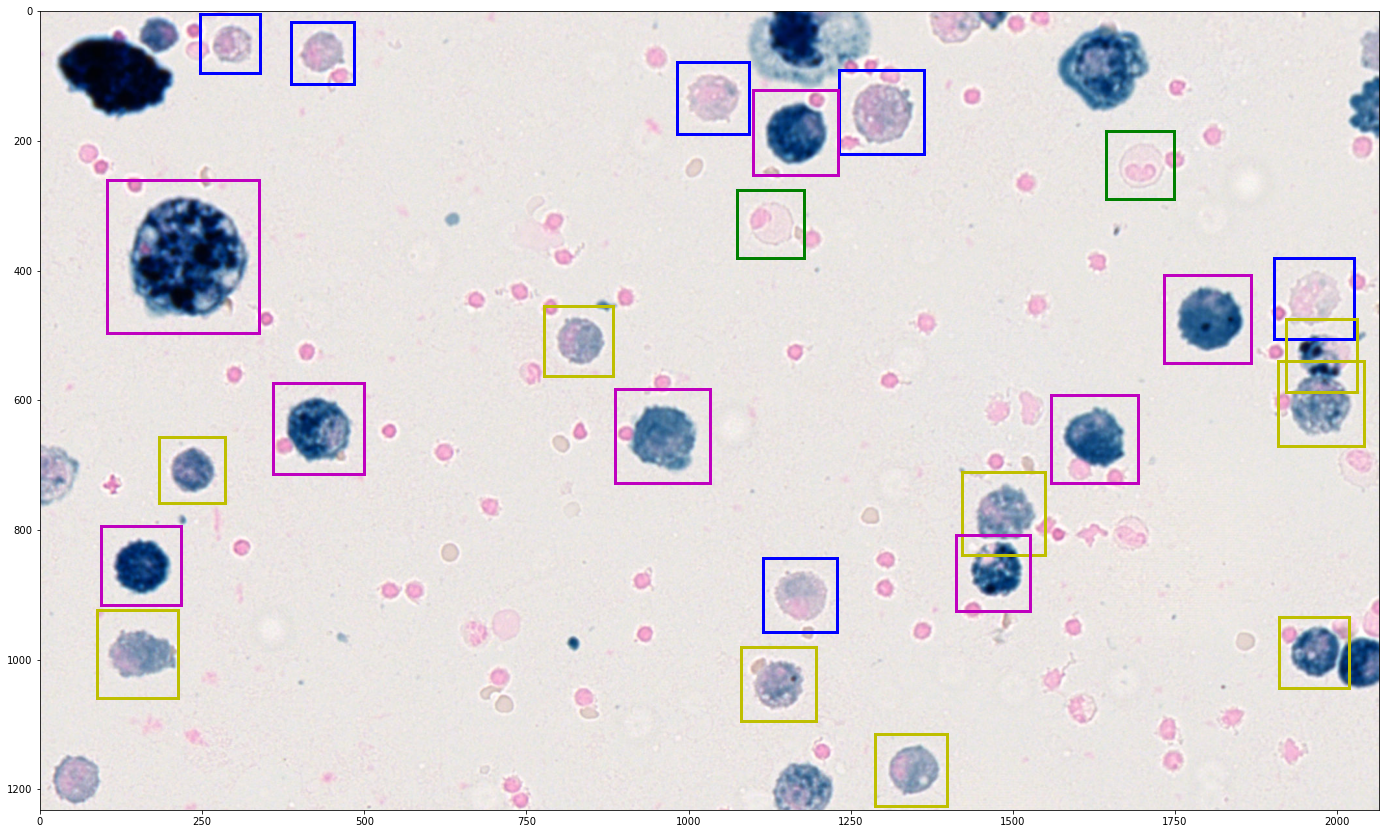

In [334]:
x_source, y_source, w_source, h_source, mpp_source  = 27435, 11221, 2065, 1232, 0.2206287920573635 #2065, 1232

source_annos = s210[(s210["x1"] > x_source) & (s210["y1"] > y_source) & (s210["x2"] < x_source + w_source) & (s210["y2"] < y_source + h_source)]

temp_source_annos = source_annos.copy()
temp_source_annos["x1"] = temp_source_annos["x1"] - x_source
temp_source_annos["x2"] = temp_source_annos["x2"] - x_source

temp_source_annos["y1"] = temp_source_annos["y1"] - y_source
temp_source_annos["y2"] = temp_source_annos["y2"] - y_source

image_source = slide_source.read_region(location=(x_source, y_source), level=0, size=(w_source, h_source))
draw_annos(image_source, temp_source_annos)

In [335]:
slide_target = openslide.OpenSlide(filename='../Slides/NanoZoomer2.0HT/N2_BB_576255_1.ndpi')
slide_target

OpenSlide('../Slides/NanoZoomer2.0HT/N2_BB_576255_1.ndpi')

In [336]:
mpp_source / mpp_target

0.972249017147671

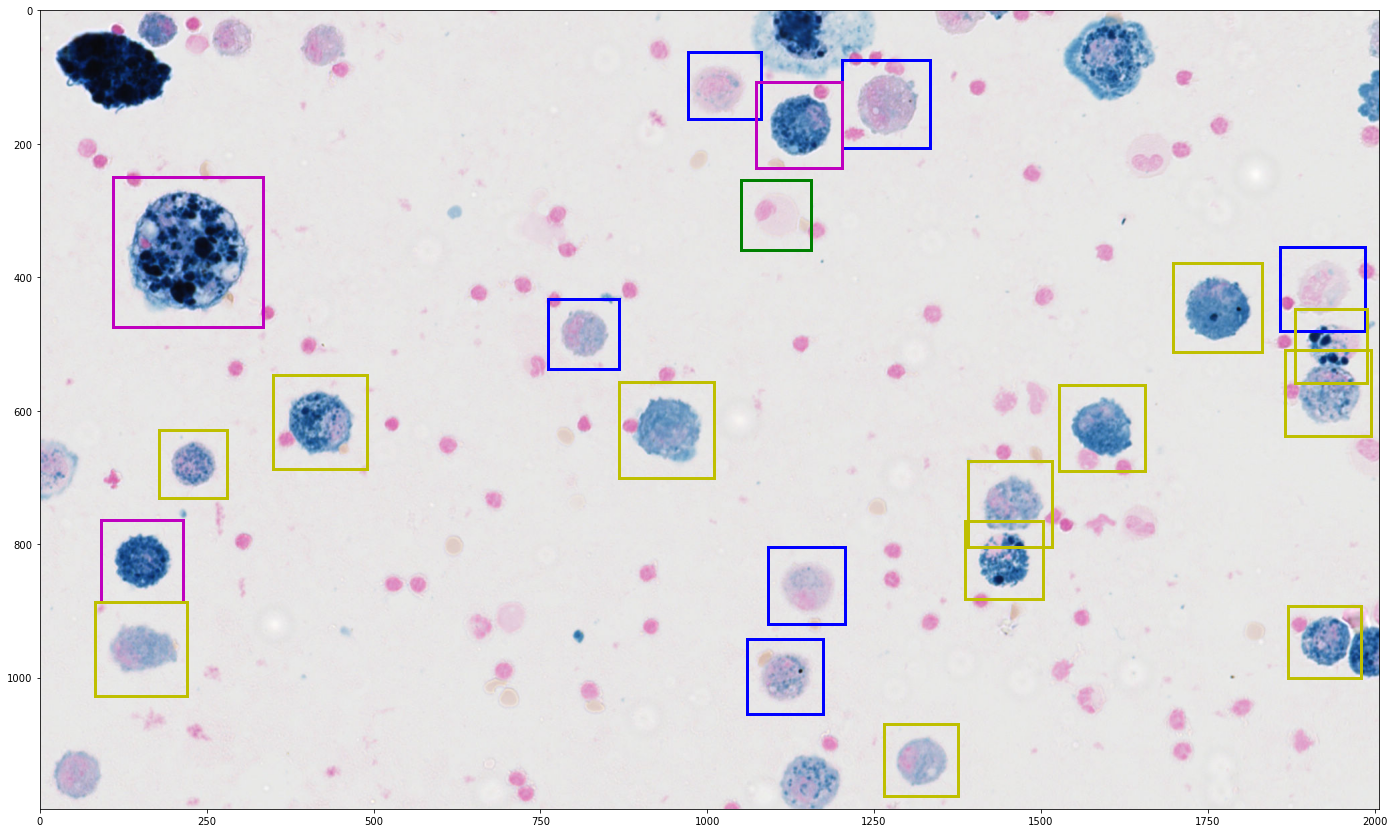

In [287]:
x_target, y_target, w_target, h_target, mpp_target = 29779, 13631, 2065, 1232, 0.22692621763160195

mpp_scale = mpp_source / mpp_target

w_target, h_target = int(w_target * mpp_scale), int(h_target * mpp_scale)

target_annos = s2[(s2["x1"] > x_target) & (s2["y1"] > y_target) & (s2["x2"] < x_target + w_target) & (s2["y2"] < y_target + h_target)]

temp_target_annos = target_annos.copy()
temp_target_annos["x1"] = temp_target_annos["x1"] - x_target
temp_target_annos["x2"] = temp_target_annos["x2"] - x_target

temp_target_annos["y1"] = temp_target_annos["y1"] - y_target
temp_target_annos["y2"] = temp_target_annos["y2"] - y_target


image_target = slide_target.read_region(location=(x_target, y_target), level=0, size=(w_target, h_target))
draw_annos(image_target, temp_target_annos)

In [288]:
source =  np.array([[center_x, center_y] for center_x, center_y in zip(source_annos["center_x"], source_annos["center_y"])])
target =  np.array([[center_x, center_y] for center_x, center_y in zip(target_annos["center_x"], target_annos["center_y"])])

print(f"Source: {source.shape}")
print(f"Target: {target.shape}")

Source: (25, 2)
Target: (22, 2)


In [397]:
b = np.array([[0.972249017147671,  0.00],       # 0.0018329
                [-0.00,  0.972249017147671]])  #-0.00519134
t = np.array([3000, 2800])   #2919.36951875, 2866.66315093

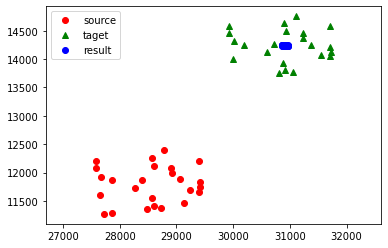

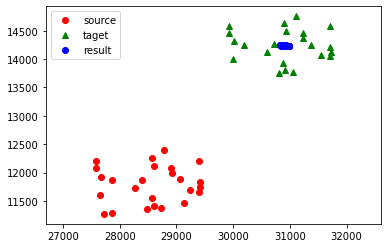

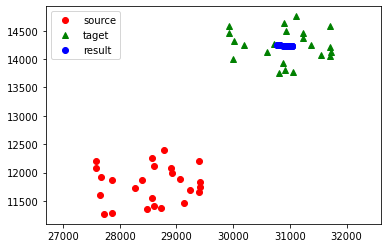

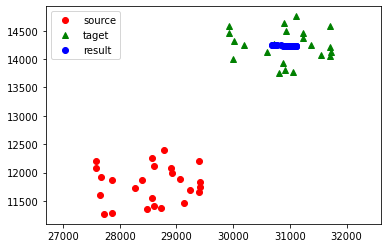

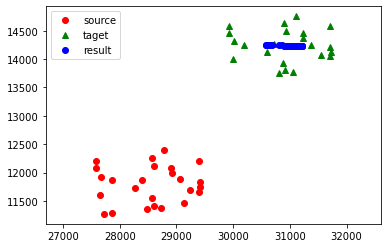

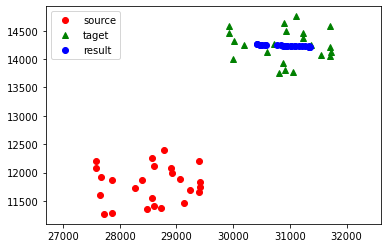

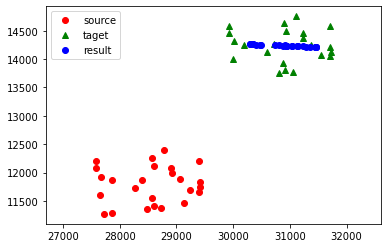

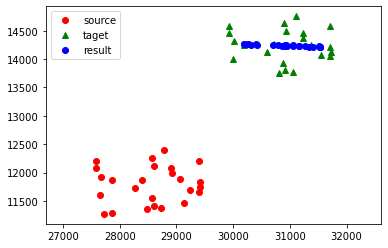

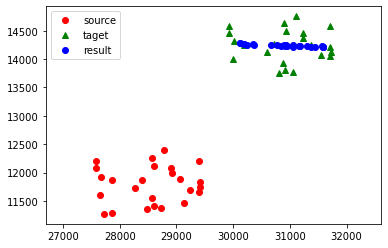

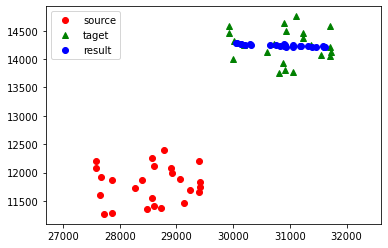

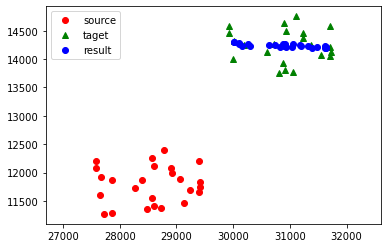

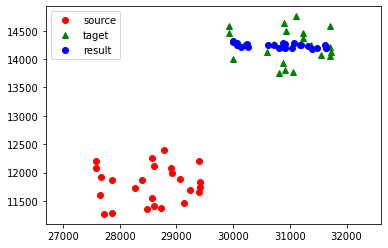

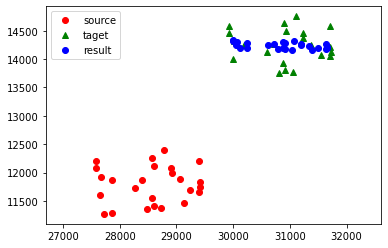

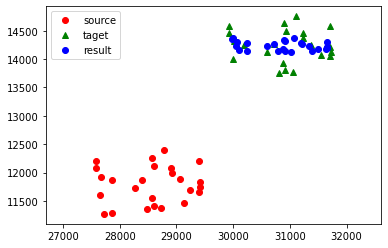

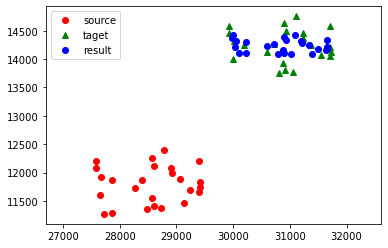

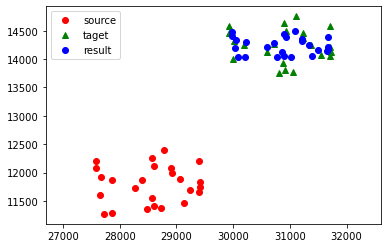

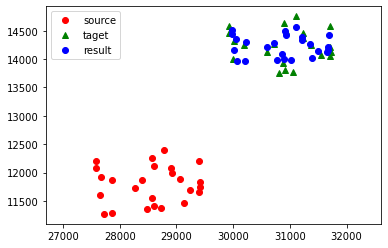

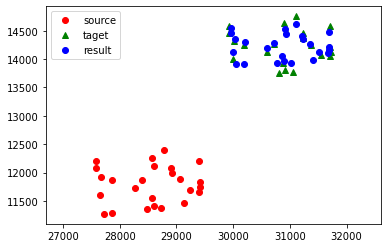

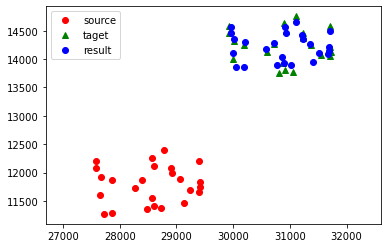

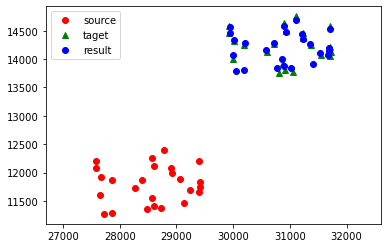

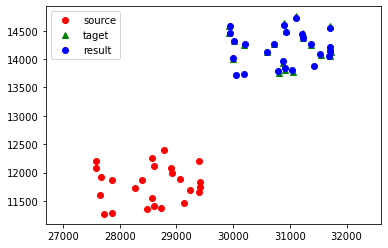

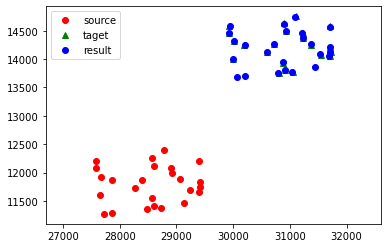

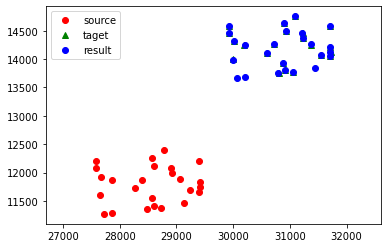

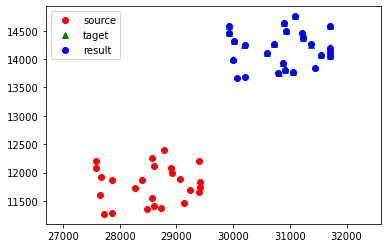

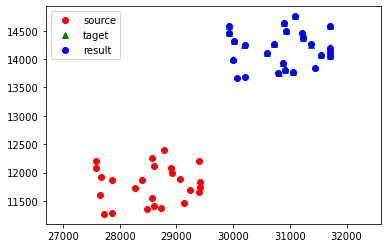

In [398]:
cbs = [callbacks.Plot2DCallback(source, target)]

tf_init_params = {"b":b, "t":t}

tf_param, _, _ = cpd.registration_cpd(source, target, 'affine', callbacks=cbs, tf_init_params=tf_init_params) # ‘rigid’, ‘affine’, ‘nonrigid’

In [290]:
tf_param.b

array([[ 0.97829725,  0.0018329 ],
       [-0.00519134,  0.97155697]])

In [291]:
tf_param.t

array([2919.36951875, 2866.66315093])

## Test

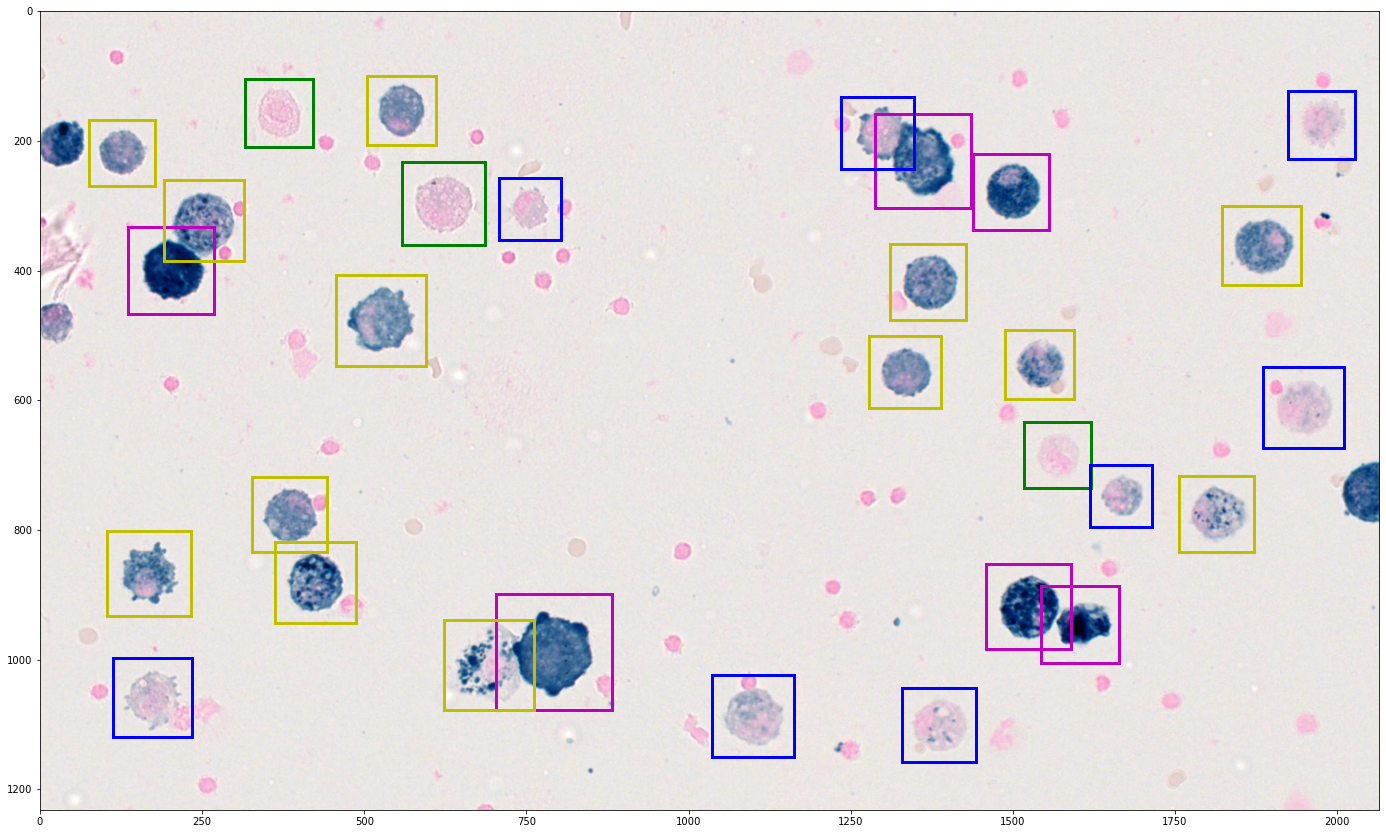

In [386]:
test_x_source, test_y_source, test_w_source, test_h_source, mpp_source  = 25779, 24631, 2065, 1232,  0.2206287920573635
#29779, 13631, 2065, 1232, 0.22692621763160195
#8166, 17980, 2048, 2048, 0.22692621763160195

test_source_annos = s210[(s210["x1"] > test_x_source) & (s210["y1"] > test_y_source) & (s210["x2"] < test_x_source + test_w_source) & (s210["y2"] < test_y_source + test_h_source)]

test_temp_source_annos = test_source_annos.copy()
test_temp_source_annos["x1"] = test_temp_source_annos["x1"] - test_x_source
test_temp_source_annos["x2"] = test_temp_source_annos["x2"] - test_x_source

test_temp_source_annos["y1"] = test_temp_source_annos["y1"] - test_y_source
test_temp_source_annos["y2"] = test_temp_source_annos["y2"] - test_y_source

test_image_source = slide_source.read_region(location=(test_x_source, test_y_source), level=0, size=(test_w_source, test_h_source))
draw_annos(test_image_source, test_temp_source_annos)

In [387]:
b = np.array([[0.972249017147671,  0.0018329],       # 0.0018329
                [-0.00519134,  0.972249017147671]])  #-0.00519134
t = np.array([2919.36951875, 2866.66315093])   #2919.36951875, 2866.66315093
tf_temp = tf.AffineTransformation(b, t)

In [388]:
transformed =  tf_param.transform(np.array([test_x_source, test_y_source])).astype(int) #tf_temp tf_param
transformed

array([28184, 26663])

In [389]:
tf_param.transform(np.array([1, 1]))

array([2920.34964891, 2867.62951655])

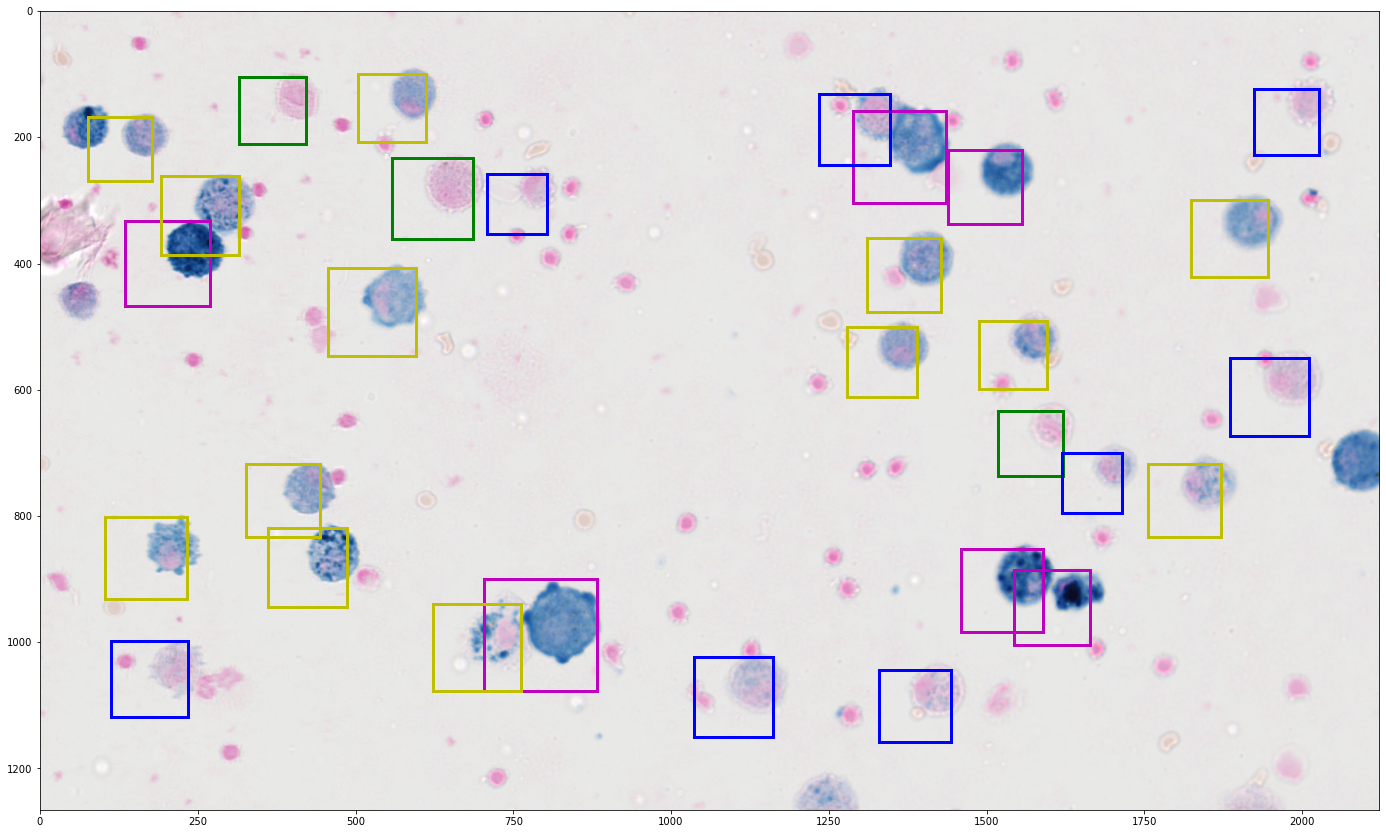

In [390]:
test_x_target, test_y_target = transformed
mpp_target = 0.22692621763160195

image_target = slide_target.read_region(location=(test_x_target, test_y_target), level=0, size=(test_w_source, test_h_source))

new_width = int(test_w_source + test_w_source * (1 - mpp_source / mpp_target))
new_height = int(test_h_source + test_h_source * (1 - mpp_source / mpp_target))
temp = image_target.resize(size=(new_width, new_height))

draw_annos(temp, test_temp_source_annos)
##draw_annos(image_target, temp_target_annos)